## MSDI MFCC Analysis

In [ ]:
import pandas as pd
import numpy as np
import tables
import h5py
import pickle

import math
import random

import os, sys, glob
from pathlib import Path

import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D

import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 3276800

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://drive.google.com/u/0/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    




In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1wduOo4DLWGEAF44odjv6BQlsxYsO_0c6/view?usp=sharing
file_id = r'1wduOo4DLWGEAF44odjv6BQlsxYsO_0c6'
# DESTINATION FILE ON YOUR DISK
destination = 'shortlisted_tracks_df.pkl' #pickle4
download_file_from_google_drive(file_id, destination)

In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1dhgh0ZPptiqBFHZ1vPhBU6-GH39k2NPY/view?usp=sharing
file_id = r'1dhgh0ZPptiqBFHZ1vPhBU6-GH39k2NPY'
# DESTINATION FILE ON YOUR DISK
destination = 'msd_data.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!rm -rf msd_data
!unzip -q msd_data.zip

In [ ]:
with open('shortlisted_tracks_df' +'.pkl', 'rb') as handle:
    shortlisted_tracks_df = pickle.load(handle)

In [ ]:
shortlisted_tracks_df

,Genre
TrackId,
TREQVVI128F427C38E,Country
TRYCYSD128F148CF20,Country
TRLCZET12903D03F70,Country
TRJORPT128F42BAA8D,Country
TROBJYA128F42A2984,Country
...,...
TRQFZEO128E07930BC,Rock
TRNSWUN128F4247F87,Rock
TRLENOU128F4281E94,Rock


In [ ]:
track_id = 'TRAAHSY128F147BB5C'
base_dir = 'msd_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4]
filepath = base_dir + '/' + track_id + '.h5'

hfile = h5py.File(filepath, 'r')

hfile.keys()

<KeysViewHDF5 ['analysis', 'metadata', 'musicbrainz']>

In [ ]:
hfile['analysis']['segments_start'].shape[0]

728

In [ ]:
hfile['analysis']['segments_timbre'][0]

array([  0.   , 171.13 ,   9.469, -28.48 ,  57.491, -50.067,  14.833,
         5.359, -27.228,   0.973, -10.64 ,  -7.228])

In [ ]:
!pip install librosa

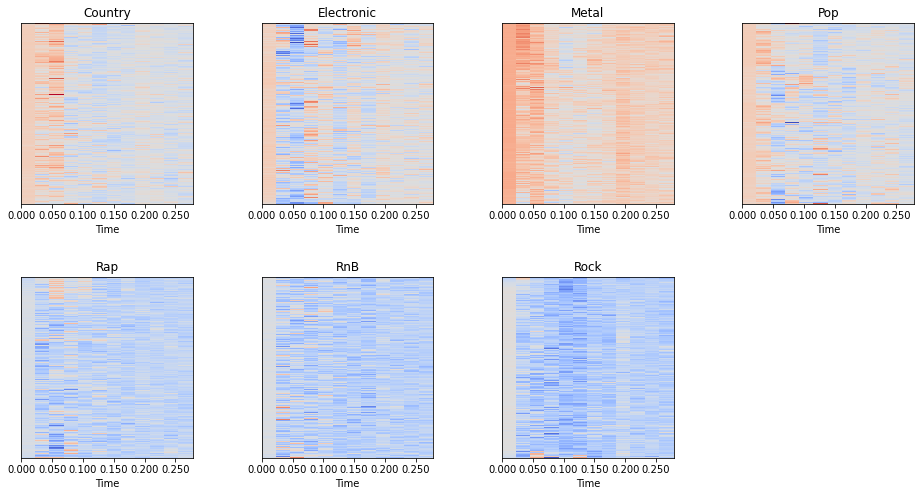

In [ ]:
import librosa
import librosa.display

sample_indices = [0, 700, 1400, 2100, 2800, 3500, 4200]
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, sample_index in enumerate(sample_indices):
  track_id = shortlisted_tracks_df.index.values[sample_index]
  genre = shortlisted_tracks_df.iloc[sample_index][0]

  filepath = 'msd_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4] + '/' + track_id + '.h5'
  hfile = h5py.File(filepath, 'r')

  #print ('mfcc plot for track_id=', track_id, " genre=", genre, " is: ")
  fig.add_subplot(2, 4, i+1)
  plt.title(genre)

  mfcc_values = np.array(hfile['analysis']['segments_timbre'])
  sr = hfile['analysis']['songs']['analysis_sample_rate'][0]
  librosa.display.specshow(mfcc_values, sr=sr, x_axis='time')

  hfile.close()

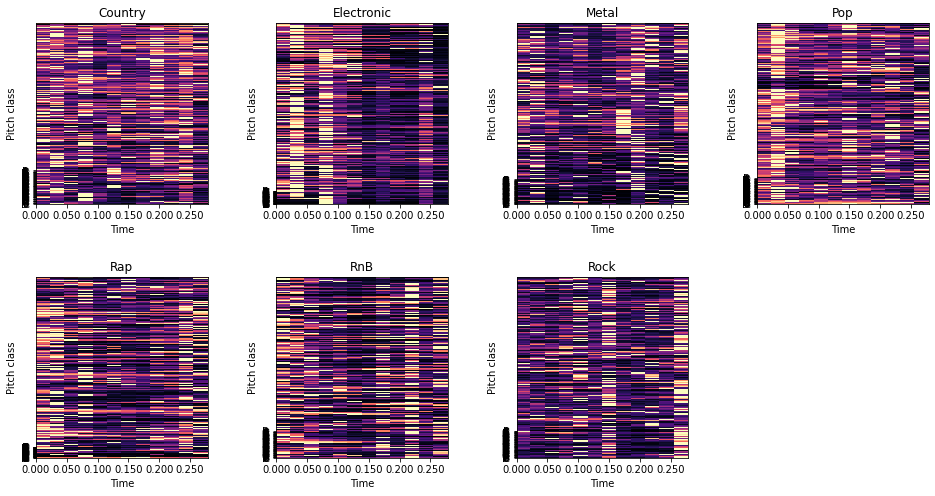

In [ ]:
import librosa
import librosa.display

sample_indices = [0, 700, 1400, 2100, 2800, 3500, 4200]
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, sample_index in enumerate(sample_indices):
  track_id = shortlisted_tracks_df.index.values[sample_index]
  genre = shortlisted_tracks_df.iloc[sample_index][0]

  filepath = 'msd_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4] + '/' + track_id + '.h5'
  hfile = h5py.File(filepath, 'r')

  #print ('mfcc plot for track_id=', track_id, " genre=", genre, " is: ")
  fig.add_subplot(2, 4, i+1)
  plt.title(genre)

  pitch_values = np.array(hfile['analysis']['segments_pitches'])
  sr = hfile['analysis']['songs']['analysis_sample_rate'][0]
  librosa.display.specshow(pitch_values, x_axis='time', y_axis='chroma', sr=sr)

  hfile.close()

In [ ]:
track_count = len(shortlisted_tracks_df.index.values)
seg_count = 65
mfcc_count = 12
min_segments = 728
max_segments = 0

msdi_mfcc_values = np.zeros((track_count, 3072, mfcc_count), dtype=np.float32)

for i, track_id in enumerate(shortlisted_tracks_df.index.values):
    base_dir = 'msd_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4]
    filepath = base_dir + '/' + track_id + '.h5'
    try:
      hfile = h5py.File(filepath, 'r')
      num_segments = hfile['analysis']['segments_start'].shape[0]
      if num_segments < min_segments:
        min_segments = num_segments

      if num_segments > max_segments:
        max_segments = num_segments

      mfcc_tmp = np.array(hfile['analysis']['segments_timbre'])
      segmax = mfcc_tmp.max()
      segmin = mfcc_tmp.min()
      seg_range = 1
      if segmax > segmin:
        seg_range = segmax-segmin
      mfcc_norm = (mfcc_tmp - segmin)/seg_range
      msdi_mfcc_values[i] = ((mfcc_norm * 2) - 1)

    except (RuntimeError, TypeError, NameError, OSError):
      print('failed for file: ', filepath)

In [ ]:
track_count = len(shortlisted_tracks_df.index.values)
seg_count = 3072
mfcc_count = 12

msdi_mfcc_values = np.zeros((track_count, seg_count, mfcc_count), dtype=np.float32)

for i, track_id in enumerate(shortlisted_tracks_df.index.values):
    filepath = 'msd_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4] + '/' + track_id + '.h5'
    try:
      hfile = h5py.File(filepath, 'r')
      num_segments = hfile['analysis']['segments_start'].shape[0]
      msdi_mfcc_values[i][:num_segments] = np.array(hfile['analysis']['segments_timbre'])
      hfile.close()

    except (RuntimeError, TypeError, NameError, OSError):
      print('failed for file: ', filepath)

In [ ]:
min_segments

65

In [ ]:
max_segments

2892

In [ ]:
msdi_mfcc_values[2].max()

171.13

In [ ]:
msdi_mfcc_values[2].min()

-191.419

In [ ]:
shortlisted_tracks_df['Genre'] = shortlisted_tracks_df['Genre'].astype('category')

In [ ]:
genre_counts = 7
msdi_genres = tf.keras.utils.to_categorical(shortlisted_tracks_df['Genre'].cat.codes, genre_counts)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(msdi_mfcc_values, msdi_genres, random_state=1)

In [ ]:
module_suffix = '_mfcc'
genre_counts = 7

In [ ]:
#Defining a function to save the objects as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
save_obj(x_train, 'x_train' + module_suffix)
save_obj(y_train, 'y_train' + module_suffix)

In [ ]:
save_obj(x_test, 'x_test' + module_suffix)
save_obj(y_test, 'y_test' + module_suffix)

In [ ]:
with open('x_train' + module_suffix +'.pkl', 'rb') as handle:
    x_train = pickle.load(handle)

with open('y_train' + module_suffix +'.pkl', 'rb') as handle:
    y_train = pickle.load(handle)

In [ ]:
with open('x_test' + module_suffix +'.pkl', 'rb') as handle:
    x_test = pickle.load(handle)

with open('y_test' + module_suffix +'.pkl', 'rb') as handle:
    y_test = pickle.load(handle)

In [ ]:
x_train.shape

(3675, 3072, 12)

In [ ]:
y_train.shape

(3675, 7)

In [ ]:
sum(np.isnan(x_train.reshape(-1)))

KeyboardInterrupt: ignored

In [ ]:
sum(np.isnan(x_test.reshape(-1)))

0

In [ ]:
#x_train[np.isnan(x_train)] = 0
#x_test[np.isnan(x_test)] = 0

In [ ]:
x_train = x_train.reshape(x_train.shape[0], seg_count, mfcc_count, 1)
x_test = x_test.reshape(x_test.shape[0], seg_count, mfcc_count, 1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=, leaf_size=3, p=1)

In [ ]:
#x_train.shape

In [ ]:
from keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 1), input_shape=x_train[0].shape, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 1), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2,1)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))

model.add(Dense(genre_counts, activation='softmax', kernel_initializer='he_uniform'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f0aabf8e050>>

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
history = model.fit(x_train, y_train, epochs=20, batch_size=64, callbacks=[callback], verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
58/58 [==============================] - 628s 11s/step - loss: 41.8600 - accuracy: 0.1502 - val_loss: 1.9458 - val_accuracy: 0.1461
Epoch 2/20
58/58 [==============================] - 633s 11s/step - loss: 1.9512 - accuracy: 0.1320 - val_loss: 1.9461 - val_accuracy: 0.1437
Epoch 3/20
58/58 [==============================] - 638s 11s/step - loss: 1.9712 - accuracy: 0.1347 - val_loss: 1.9462 - val_accuracy: 0.1437
Epoch 4/20
 9/58 [===>..........................] - ETA: 8:19 - loss: 1.9457 - accuracy: 0.1441

KeyboardInterrupt: ignored